In [2]:
import numpy as np
import matplotlib.pyplot as plt
from aeons.utils import *
from aeons.regress import *
from aeons.endpoint import *
from aeons.plotting import *
figsettings()

In [100]:
def logXf_beta_DKL_boot(points, ndead, Nset=25, Nresample=50):
    logL, X_mean, nk, logZdead = data(points)
    beta_DKL = get_beta(points, ndead)
    dG = points.set_beta(beta_DKL).d_G(Nset).values
    logXf_set = np.zeros(Nset)
    for i in range(Nset):
        window = np.sort(np.random.choice(np.arange(ndead, len(logL)), Nresample))
        X = generate_Xs(nk)
        logLd = logL[window]
        Xd = X[window]
        d = np.random.choice(dG)
        theta = params_from_d(logLd, Xd, d)
        logXf_set[i] = logXf_formula(theta, logZdead, X_mean[ndead])
    logXf_set = logXf_set[~np.isnan(logXf_set)]
    # logXf_set = reject_outliers(logXf_set)
    return logXf_set, f"{len(logXf_set)} samples, {dG.mean():.1f}"

def logXf_combined(points, ndead, Nset=25):
    logL, X_mean, nk, logZdead = data(points)
    beta_DKL = get_beta(points, ndead)
    dG = points.set_beta(beta_DKL).d_G(Nset).values
    ds = np.zeros(Nset)
    for i in range(Nset):
        X = generate_Xs(nk)
        ds[i] = analytic_lm_params(logL[ndead:], X[ndead:], d0=1)[1]
    dG_mean, dG_std = dG.mean(), 5*dG.std()
    d_mean, d_std = ds.mean(), ds.std()
    dcomb = (dG_mean*d_std**2 + d_mean*dG_std**2)/(d_std**2 + dG_std**2)
    dcomb_std = np.sqrt((d_std**2 * dG_std**2)/(d_std**2 + dG_std**2))
    
    logXf_set = np.zeros(Nset)
    for j in range(Nset):
        d = np.random.normal(dcomb, dcomb_std)
        theta = params_from_d(logL[ndead:], X_mean[ndead:], d)
        logXf_set[j] = logXf_formula(theta, logZdead, X_mean[ndead])
    logXf_set = logXf_set[~np.isnan(logXf_set)]
    # logXf_set = reject_outliers(logXf_set)
    return logXf_set, f"{len(logXf_set)} samples, {dcomb:.1f} +/- {dcomb_std:.1f}"

In [66]:
dim = 32
name, samples = get_samples('toy', f'gauss_{dim}')
model = EndModel(samples)
true_endpoint = model.true_endpoint()
true_logXf = model.true_logXf()

(-100.0, -80.0)

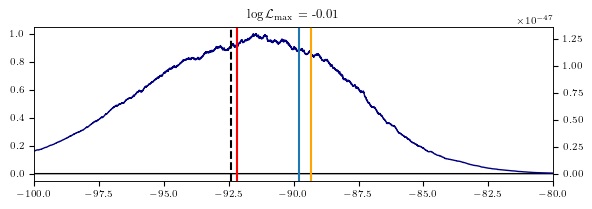

In [108]:
plot_lx(samples)
d, sigma = dim, 0.01
ElogX = d/2 * (np.log(sigma**2) + np.log(d) - 1/d)
plt.axvline(ElogX, color='k', ls='--', label='E[logX]')
plt.axvline(samples.logX().mean(), color='red')
plt.axvline(samples.logX().mean() + 1/2 * np.log(d/2) + 1)
plt.axvline(-samples.D_KL(), color='orange')
plt.xlim(-100, -80)

In [93]:
samples.D_KL(10)

samples
0    89.166565
1    90.348295
2    89.248478
3    89.186351
4    88.907246
5    89.428528
6    89.663707
7    89.990875
8    89.472679
9    90.037108
Name: D_KL, dtype: float64

In [70]:
from scipy.special import loggamma
d/2 * (np.log(sigma**2) + np.log(2*np.e)) + loggamma(1 + d/2) 

-89.60323095657911

In [84]:
d/2 * (np.log(sigma**2) + np.log(d)) + 0.5*np.log(d/2), -samples.D_KL()

(-90.52737714570338, -89.34724298606726)

In [71]:
0.5*np.log(2*np.pi)

0.9189385332046727

In [27]:
name, samples = get_samples('toy', 'cauchy_83')
model = EndModel(samples)
true_endpoint = model.true_endpoint()
true_logXf = model.true_logXf()

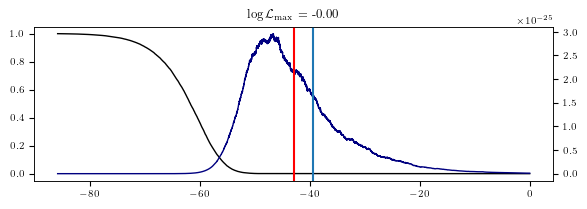

In [30]:
plot_lx(samples)
plt.axvline(samples.logX().mean(), color='red')
plt.axvline(-samples.D_KL())

In [79]:
ndead = 10000
points = model.points(ndead)
logL, X_mean, nk, logZdead = data(points)
beta_DKL = get_beta(points, ndead)
dG = points.set_beta(beta_DKL).d_G(25).values
Nset = 25
ds = np.zeros(Nset)
for i in range(Nset):
    X = generate_Xs(nk)
    theta = analytic_lm_params(logL[ndead:], X[ndead:], d0=1)
    ds[i] = theta[1]

In [102]:
ndead = 5000
points = model.points(ndead)
logXf_basic(points, ndead)

(array([-9.04290593, -8.85116022, -8.88593412, -9.03185001, -9.03395118,
        -8.87814199, -9.11021   , -9.0083727 , -8.96616095, -9.11099868,
        -8.97000754, -9.00641949, -9.11403775, -9.10838665, -8.9438996 ,
        -8.89404097, -9.18811414, -8.82375264, -8.99392716, -8.93790565,
        -9.08972622, -9.08265021, -8.85874488, -9.13416375]),
 '24 samples')

In [104]:
ndead = 5000
points = model.points(ndead)
logXf_beta_DKL(points, ndead)

(array([-7.31679636, -7.11995673, -7.28269796, -7.27660946, -7.38662504,
        -7.35509772, -7.33662897, -7.46898954, -7.69489328, -7.46950624,
        -7.66636386, -7.22886836, -7.32214631, -7.26676443, -7.55206276,
        -7.26279039, -7.63443417, -7.25120565, -7.29741051, -7.55675063,
        -7.23641371, -7.3790725 , -7.44867603, -7.3691826 , -7.40116551]),
 '25 samples, 1.1')

In [105]:
ndead = 5000
points = model.points(ndead)
logXf_combined(points, ndead)

(array([-8.7783488 , -8.7873626 , -8.41956501, -8.7817414 , -8.40342252,
        -8.59185208, -8.75124441, -8.50298105, -8.92073978, -8.66558817,
        -8.76219274, -8.38911391, -8.59339724, -8.53318829, -8.73474704,
        -9.04245563, -8.79419245, -8.61649214, -8.60048333, -8.68237673,
        -8.76271855, -8.58280925, -9.09223661, -8.83591612, -8.97483575]),
 '25 samples, 1.4 +/- 0.0')

In [115]:
iterations = make_iterations(true_endpoint, 25)
logXfs, logXfs_std = model.logXfs(logXf_combined, iterations, Nset=25)

 Iteration 39155 of 51318, 25 samples, 36.9 +/- 12.8

/home/zixiao/Documents/III/project/aeons/aeons/regress.py:29: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(sigma_squared_analytic(d, Xdata, logLdata))
/tmp/ipykernel_65878/2698236031.py:7: RuntimeWarning: invalid value encountered in log
  logdead = logZdead - logLmax - (d/2)*np.log(2) - d*np.log(sigma) + np.log(2/d)


 Iteration 51318 of 51318, 25 samples, 32.2 +/- 5.48

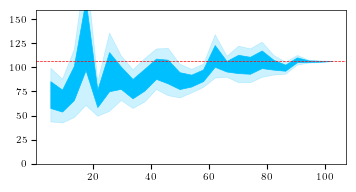

In [116]:
logXs = get_logXs(samples, iterations)
plot_std(-logXs, -logXfs, logXfs_std, -true_logXf, ylim=(0, 1.5))

In [16]:
# for i, chain in enumerate(lcdm_chains):
#     name, samples = get_samples('lcdm', chain)
#     model = EndModel(samples)
#     true_endpoint = model.true_endpoint()
#     iterations = make_iterations(true_endpoint, 25)
#     logXfs, logXfs_std = model.logXfs(logXf_beta_DKL, iterations, Nset=25)
#     write_to_txt(f'{aeons_dir}/data/predictions/lcdm/logXfs_dG_DKL/{chain}.txt', [iterations, logXfs, logXfs_std, true_endpoint])
#     print(f' {chain} done, {i+1}/{len(lcdm_chains)}')

 Iteration 17440 of 17440, 25 samples, 2.2 BAO done, 1/11
 Iteration 18310 of 18310, 25 samples, 1.8 lensing done, 2/11
 Iteration 21267 of 21267, 25 samples, 3.2 lensing_BAO done, 3/11
 Iteration 19886 of 19886, 25 samples, 2.7 lensing_SH0ES done, 4/11
 Iteration 14522 of 14522, 25 samples, 0.9 SH0ES done, 5/11
 Iteration 55191 of 55191, 25 samples, 17.3 planck done, 6/11
 Iteration 56003 of 56003, 25 samples, 17.7 planck_BAO done, 7/11
 Iteration 55892 of 55892, 25 samples, 17.3 planck_lensing done, 8/11
 Iteration 55241 of 55241, 25 samples, 17.0 planck_SH0ES done, 9/11
 Iteration 55653 of 55653, 25 samples, 16.8 planck_lensing_BAO done, 10/11
 Iteration 55826 of 55826, 25 samples, 17.1 planck_lensing_SH0ES done, 11/11
